# This is tutorial using TabNetClassifier 
    https://github.com/dreamquark-ai/tabnet (orginal code information)
    This includes Cross Validation test and Hyper parameter tuning
    this code is only for classifcation at the moment (soon I will make tutorial for regressor)


## import libraries

    set target feature and unused function.
    All features need to be float. 

In [9]:
from torch import nn
import torch
from torch import tensor 
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm

train_data= pd.read_csv('./data/train.ct.csv')
test_data= pd.read_csv('./data/test.ct.csv')
target ='sex'
unused_feat = ['Set', 'subjectkey', 'race.ethnicity', 'abcd_site', 'Unnamed: 0', 'fsqc_qc.y', 'kflod']
Num_FOLDS  = 5
# the number of feature that you want to show 
Num_feat = 5

## Define preproecessing: fillna as 0, set kflod

In [10]:
def preproecessing (train_data, test_data, NUM_FOLDS):
    test_data_processed= test_data.fillna(0).reset_index(drop=True)
    train_data_processed = train_data.fillna(0).reset_index(drop=True)
    
    test_data_processed["kfold"] = -1

    train_data_processed["kfold"] = -1

    train_data_processed = train_data_processed.sample(frac=1,random_state=2020).reset_index(drop=True)

    kf = KFold(n_splits=NUM_FOLDS)

    for fold, (trn_, val_) in enumerate(kf.split(X=train_data_processed, y=train_data_processed)):
        train_data_processed.loc[val_, 'kfold'] = fold
    print("done preprocessing")
    return train_data_processed, test_data_processed

## Define function of finding best hyperparameters

In [31]:
# Augmented
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm


def find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test):
    # Store maximum auc
    max_auc= 0
    # Store maximum hypterparameter set
    max_hy = []
    # define hyperparameter space
    """
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    # Orginal hyperparameter space 
    """
    # define hyperparameter space (quick version)
    n_ = [4]
    lr_ = [2e-2]
    w_ = [0.01]
    g_ = [0.95]
    ss_ = [10, 20]
    
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    
    for hy in tqdm(h_space):
        clf = TabNetClassifier(n_a = hy[0],
                               n_d = hy[0],
                               optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                               scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                               scheduler_fn=torch.optim.lr_scheduler.StepLR,
                               verbose=0
                               )
        clf.fit(X_train, Y_train, X_valid, Y_valid, patience=10, batch_size=256, max_epochs=200)
        #clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200) (Recommended)
        preds_acc = clf.predict(X_test)
        preds_prob = clf.predict_proba(X_test)
        test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
        test_acc = accuracy_score(preds_acc, Y_test)
        print("--------Test auc: {} Test acc:{}-------------".format(test_auc, test_acc) )
        if test_auc>max_auc:
            max_hy = hy
            max_auc = test_auc
    return max_hy

## Do it with best hyperparameter 

In [12]:
def bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, max_hy):
 
    hy = max_hy
    clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                               )
    clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200)
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
    test_acc = accuracy_score(preds_acc, Y_test)
    print("Max hy:" ,hy)
    print("FINAL TEST SCORE(max) test auc: {} test acc: {}".format(test_auc, test_acc))
    return test_auc, clf
    
          

## Find importance feature 

In [33]:
def feature(Num_feat, clf, test_data_processed, features):
    importance =clf.feature_importances_
    plt.plot(importance)
    plt.show()
    labels_importance=importance.argsort()[::-1]

    importance_sort = np.sort(importance)[::-1]

    feat_name_sort=test_data_processed[features].columns[labels_importance]
    important_features = pd.DataFrame() 


    for i in range (Num_feat):
        feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['feature name', 'ratio'])
        important_features=pd.concat([important_features,feature])

    print(important_features.reset_index(drop=True))

## Define run(find best par, learn with best par, show feature) function 
    set X_test, Y_test, X_train, Y_train, X_valid, Y_valid

In [30]:

def run(train_data_processed, test_data_processed, fold, Num_feat, features):
    X_test = test_data_processed[features].values
    Y_test = test_data_processed[target].values

    df_train = train_data_processed[train_data_processed.kfold != fold]
    df_valid = train_data_processed[train_data_processed.kfold == fold]
    
    X_train = df_train[features].values
    Y_train = df_train[target].values
    
    X_valid = df_valid[features].values
    Y_valid = df_valid[target].values
    
    y_oof = np.zeros((df_valid.shape[0],len(target)))   # Out of folds validation
    
    print("--------Training Begining for fold {}-------------".format(fold+1))
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    # Start training
    max_hy = find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test)
    print("Found maximum hyperparmeter, now work with that")
    test_auc, clf = bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, max_hy)
    
    feature(Num_feat, clf, test_data_processed, features)
    
    return test_auc
    
    # VISUALIZTION
    #plt.figure(figsize=(12,6))
    #plt.plot(model.history['train']['loss'])
    #plt.plot(model.history['valid']['loss'])
    
    #Plotting Metric
    #plt.plot([-x for x in model.history['train']['metric']])
    #plt.plot([-x for x in model.history['valid']['metric']])

## Definde function for Cross Validation test 

In [28]:
def hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat):
    CV_auc_all = []
    train_data_processed, test_data_processed = preproecessing (train_data, test_data, Num_FOLDS)
    
    features = [ col for col in train_data_processed.columns if col not in unused_feat + [target]] 
    
    for i in range(Num_FOLDS):
        test_auc = run(train_data_processed, test_data_processed, i, Num_feat, features)
        print ("--------Test auc: {} for fold {}-------------".format(test_auc, i+1))
        print ("                                             ")
        print ("---------------------------------------------")
        CV_auc_all.append(test_auc)
    print(CV_auc_all)

## Finally! you can do hyperparametertuning with Cross validation


done preprocessing
--------Training Begining for fold 1-------------


Device used : cuda
--------Test auc: 0.842874614540323 Test acc:0.7301992846193153-------------
Device used : cuda
--------Test auc: 0.842874614540323 Test acc:0.7301992846193153-------------

Device used : cuda
Max hy: (4, 0.02, 0.01, 0.95, 10)
FINAL TEST SCORE(max) test auc: 0.8480823707730099 test acc: 0.7496167603474706


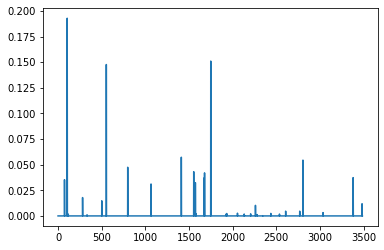

              feature name     ratio
0  con_L.CACG_L.RACG_count  0.192914
1   con_L.RACG_R.LOG_count  0.151109
2    con_L.IPG_R.STG_count  0.147737
3   con_L.PCAL_L.SFG_count  0.057283
4    con_R.HI_R.PoCG_count  0.054463
--------Test auc: 0.8480823707730099 for fold 1-------------
---------------------------------------------
--------Training Begining for fold 2-------------


Device used : cuda
--------Test auc: 0.8461908744054774 Test acc:0.7051609606540623-------------
Device used : cuda
--------Test auc: 0.8542455443474626 Test acc:0.5978538579458355-------------

Device used : cuda
Max hy: (4, 0.02, 0.01, 0.95, 20)
FINAL TEST SCORE(max) test auc: 0.8486781999686406 test acc: 0.7659683188553909


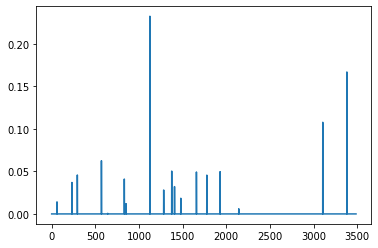

              feature name     ratio
0  con_L.PHIG_R.PoCG_count  0.232433
1   con_R.PoCG_R.PCG_count  0.166904
2    con_R.IPG_R.TTG_count  0.107732
3    con_L.ITG_L.PTR_count  0.062542
4     con_L.PTR_R.EC_count  0.050356
--------Test auc: 0.8486781999686406 for fold 2-------------
---------------------------------------------
--------Training Begining for fold 3-------------


Device used : cuda
--------Test auc: 0.8565922751267444 Test acc:0.7833418497700562-------------
Device used : cuda
--------Test auc: 0.8625756546281294 Test acc:0.6647930505876342-------------

Device used : cuda
Max hy: (4, 0.02, 0.01, 0.95, 20)
FINAL TEST SCORE(max) test auc: 0.8578361992369206 test acc: 0.7828308635666837


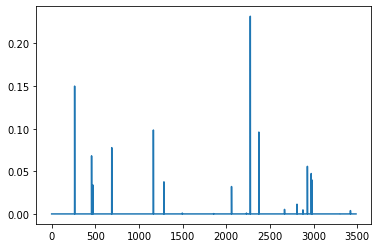

             feature name     ratio
0  con_L.CER_R.BSTS_count  0.231914
1    con_L.CU_L.PCG_count  0.149946
2   con_L.PaCG_L.AC_count  0.098422
3     con_L.CA_R.CU_count  0.096003
4  con_L.ICG_R.MOFG_count  0.077769
--------Test auc: 0.8578361992369206 for fold 3-------------
---------------------------------------------
--------Training Begining for fold 4-------------


Device used : cuda
--------Test auc: 0.8448063555114199 Test acc:0.5528870720490546-------------
Device used : cuda
--------Test auc: 0.8448063555114199 Test acc:0.5528870720490546-------------

Device used : cuda
Max hy: (4, 0.02, 0.01, 0.95, 10)
FINAL TEST SCORE(max) test auc: 0.8448063555114199 test acc: 0.5528870720490546


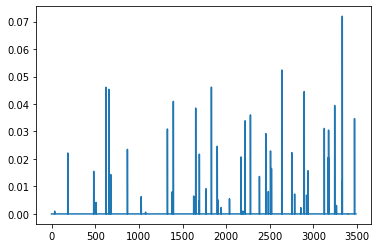

            feature name     ratio
0  con_R.POP_R.TTG_count  0.071937
1   con_R.TH_R.IPG_count  0.052363
2  con_L.RMFG_R.IN_count  0.046142
3  con_L.ITG_R.PCU_count  0.046084
4  con_L.ICG_L.SMG_count  0.045342
--------Test auc: 0.8448063555114199 for fold 4-------------
---------------------------------------------
--------Training Begining for fold 5-------------


Device used : cuda
--------Test auc: 0.8498824021324413 Test acc:0.7634133878385284-------------
Device used : cuda
--------Test auc: 0.8413118695447656 Test acc:0.7644353602452734-------------

Device used : cuda
Max hy: (4, 0.02, 0.01, 0.95, 10)
FINAL TEST SCORE(max) test auc: 0.8404902524434225 test acc: 0.6729688298415942


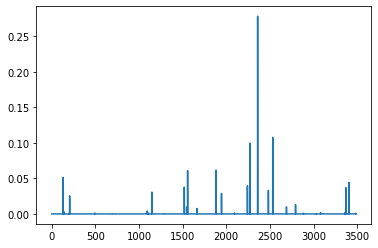

            feature name     ratio
0    con_L.CA_L.PA_count  0.278489
1   con_L.HI_R.SPG_count  0.107851
2   con_L.CER_R.HI_count  0.099766
3  con_L.SFG_R.STG_count  0.061706
4   con_L.PCG_R.HI_count  0.060978
--------Test auc: 0.8404902524434225 for fold 5-------------
---------------------------------------------
[0.8480823707730099, 0.8486781999686406, 0.8578361992369206, 0.8448063555114199, 0.8404902524434225]


In [34]:
"""
train_data= pd.read_csv('./data/train.ct.csv')
test_data= pd.read_csv('./data/test.ct.csv')
target ='sex'
unused_feat = ['Set', 'subjectkey', 'race.ethnicity', 'abcd_site', 'Unnamed: 0', 'fsqc_qc.y', 'kflod']
Num_FOLDS  = 5
# the number of feature that you want to show 
Num_feat = 5

"""    

hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat)
